In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import torch
from torch import nn,optim
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import random
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader


In [2]:
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)
labels_list

['benign', 'malignant']

### Read Data

In [3]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)
    
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)
    


In [4]:
data=pd.DataFrame({"images":images,"labels":labels})
data

images     labels
0     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
1     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
2     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
3     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
4     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
...                                                 ...        ...
2632  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2633  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2634  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2635  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2636  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant

[2637 rows x 2 columns]

In [5]:
data.labels.value_counts()

labels
benign       1440
malignant    1197
Name: count, dtype: int64

### VIS DATA

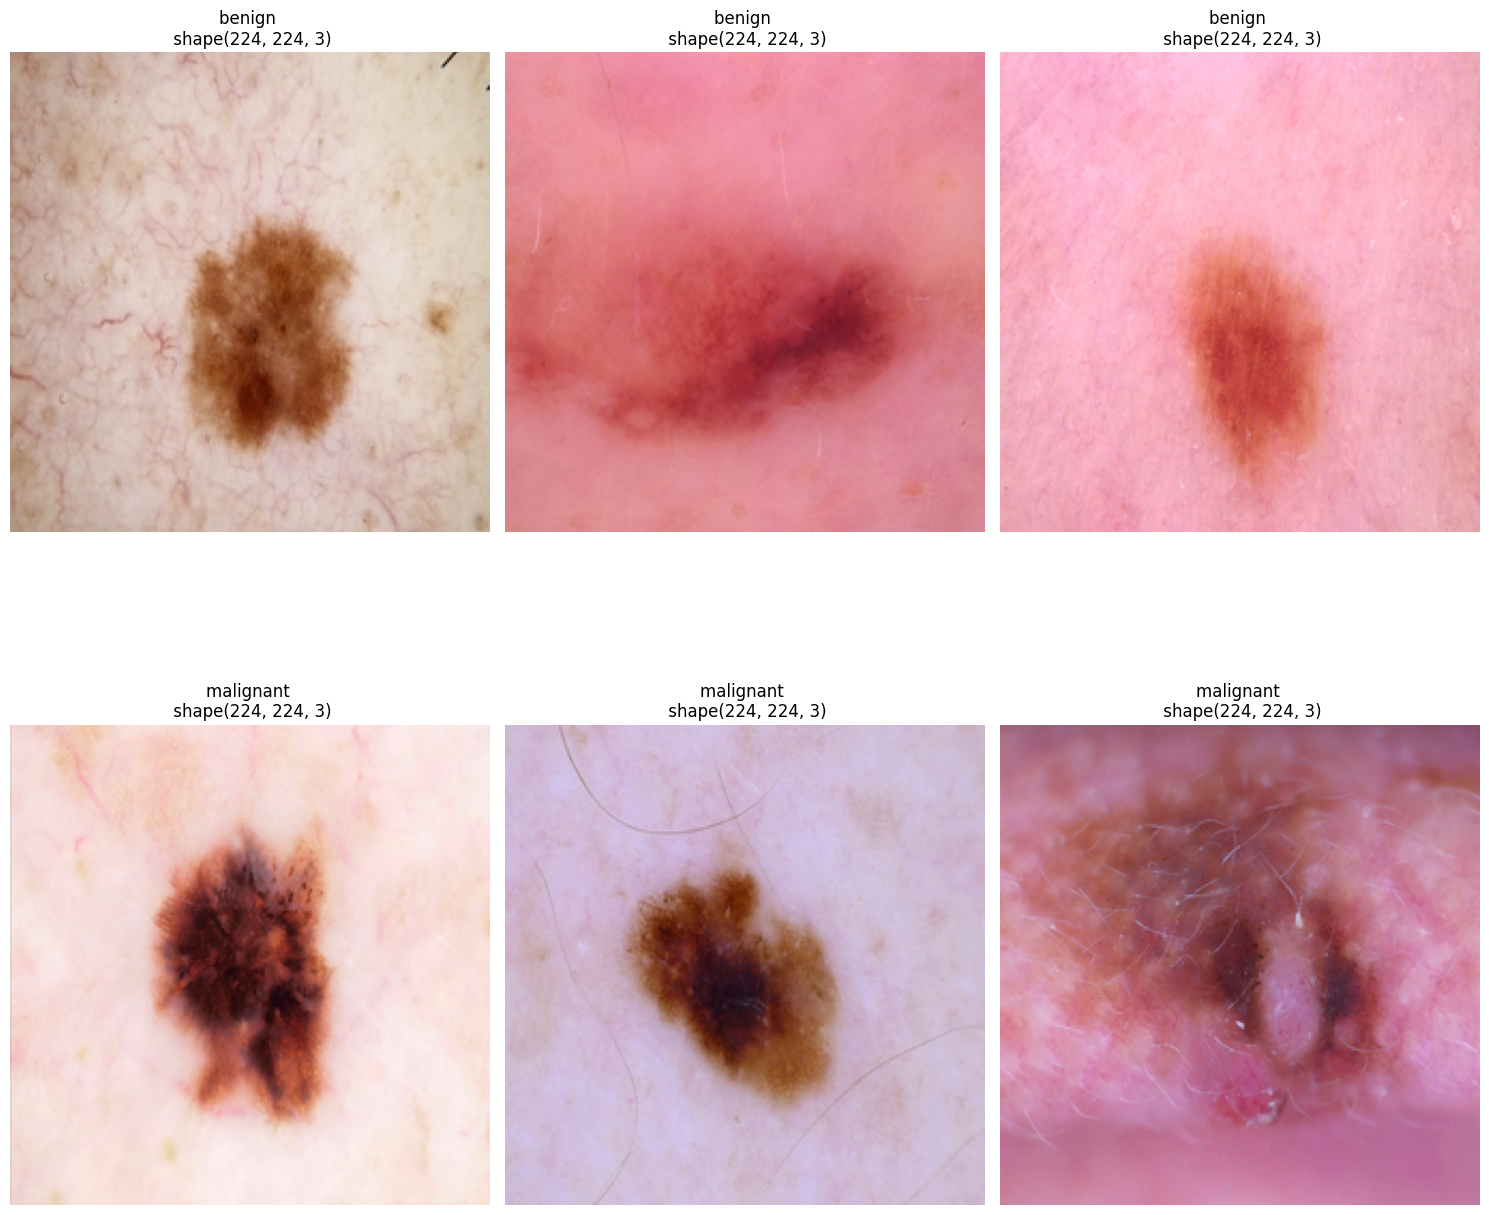

In [6]:
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:
    
    img=data["images"][data["labels"]==label]
    select_images= random.choices(img.values,k=3)
    
    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

### Split data

In [7]:
train_data,val=train_test_split(data,test_size=0.2,random_state=123)

In [8]:
label2=dict(zip(labels_list,range(len(labels_list))))
label2

{'benign': 0, 'malignant': 1}

### CustomDataset

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame, label2:dict, transforms = None):
        
        self.data = data
        self.label2 = label2
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        data_new['labels'] = data_new['labels'].map(self.label2)
        
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        target = data_new.iloc[idx, 1]
        
        return image, target

In [10]:
from torchvision.models import ResNet50_Weights

weights=ResNet50_Weights.DEFAULT
img_transforms=weights.transforms()
img_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
train_dataset=CustomImageDataset(data=train_data,label2=label2,transforms=img_transforms)
val_dataset=CustomImageDataset(data=val,label2=label2,transforms=img_transforms)
train_dataset[2]

(tensor([[[0.4679, 0.5364, 0.5707,  ..., 0.7591, 0.7248, 0.6734],
          [0.5193, 0.5022, 0.5364,  ..., 0.7933, 0.7591, 0.6906],
          [0.5878, 0.5022, 0.5536,  ..., 0.8104, 0.7933, 0.7248],
          ...,
          [0.7933, 0.8961, 0.9474,  ..., 0.8276, 0.8447, 0.8789],
          [0.8104, 0.8789, 0.8789,  ..., 0.8447, 0.8104, 0.8276],
          [0.8447, 0.8618, 0.8618,  ..., 0.8104, 0.7762, 0.7762]],
 
         [[0.0476, 0.1352, 0.1702,  ..., 0.6254, 0.5903, 0.5203],
          [0.1001, 0.1176, 0.1527,  ..., 0.6604, 0.5903, 0.5203],
          [0.1527, 0.0826, 0.1352,  ..., 0.6604, 0.6078, 0.5378],
          ...,
          [0.6429, 0.7654, 0.8179,  ..., 0.6604, 0.7129, 0.7304],
          [0.6604, 0.7479, 0.7479,  ..., 0.6779, 0.6429, 0.6604],
          [0.6954, 0.7479, 0.7129,  ..., 0.6429, 0.6078, 0.5553]],
 
         [[0.2871, 0.3916, 0.4614,  ..., 0.8797, 0.8797, 0.8971],
          [0.3393, 0.3568, 0.4265,  ..., 0.8971, 0.8448, 0.8274],
          [0.3742, 0.3393, 0.4091,  ...,

In [12]:
def show_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    print("Labels:", labels)

# Display labels from the train dataset
show_labels(train_dataset)

Labels: [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1

In [13]:
batchsize=32

train_loader=DataLoader(dataset=train_dataset,
                       batch_size=batchsize,
                       shuffle=True,
                       num_workers=4,
                       )
val_loader=DataLoader(dataset=val_dataset,
                       batch_size=batchsize,
                       shuffle=True,
                       num_workers=4,
                       )

In [14]:
batch = next(iter(train_loader))

batch_images = batch[0]
batch_labels = batch[1]

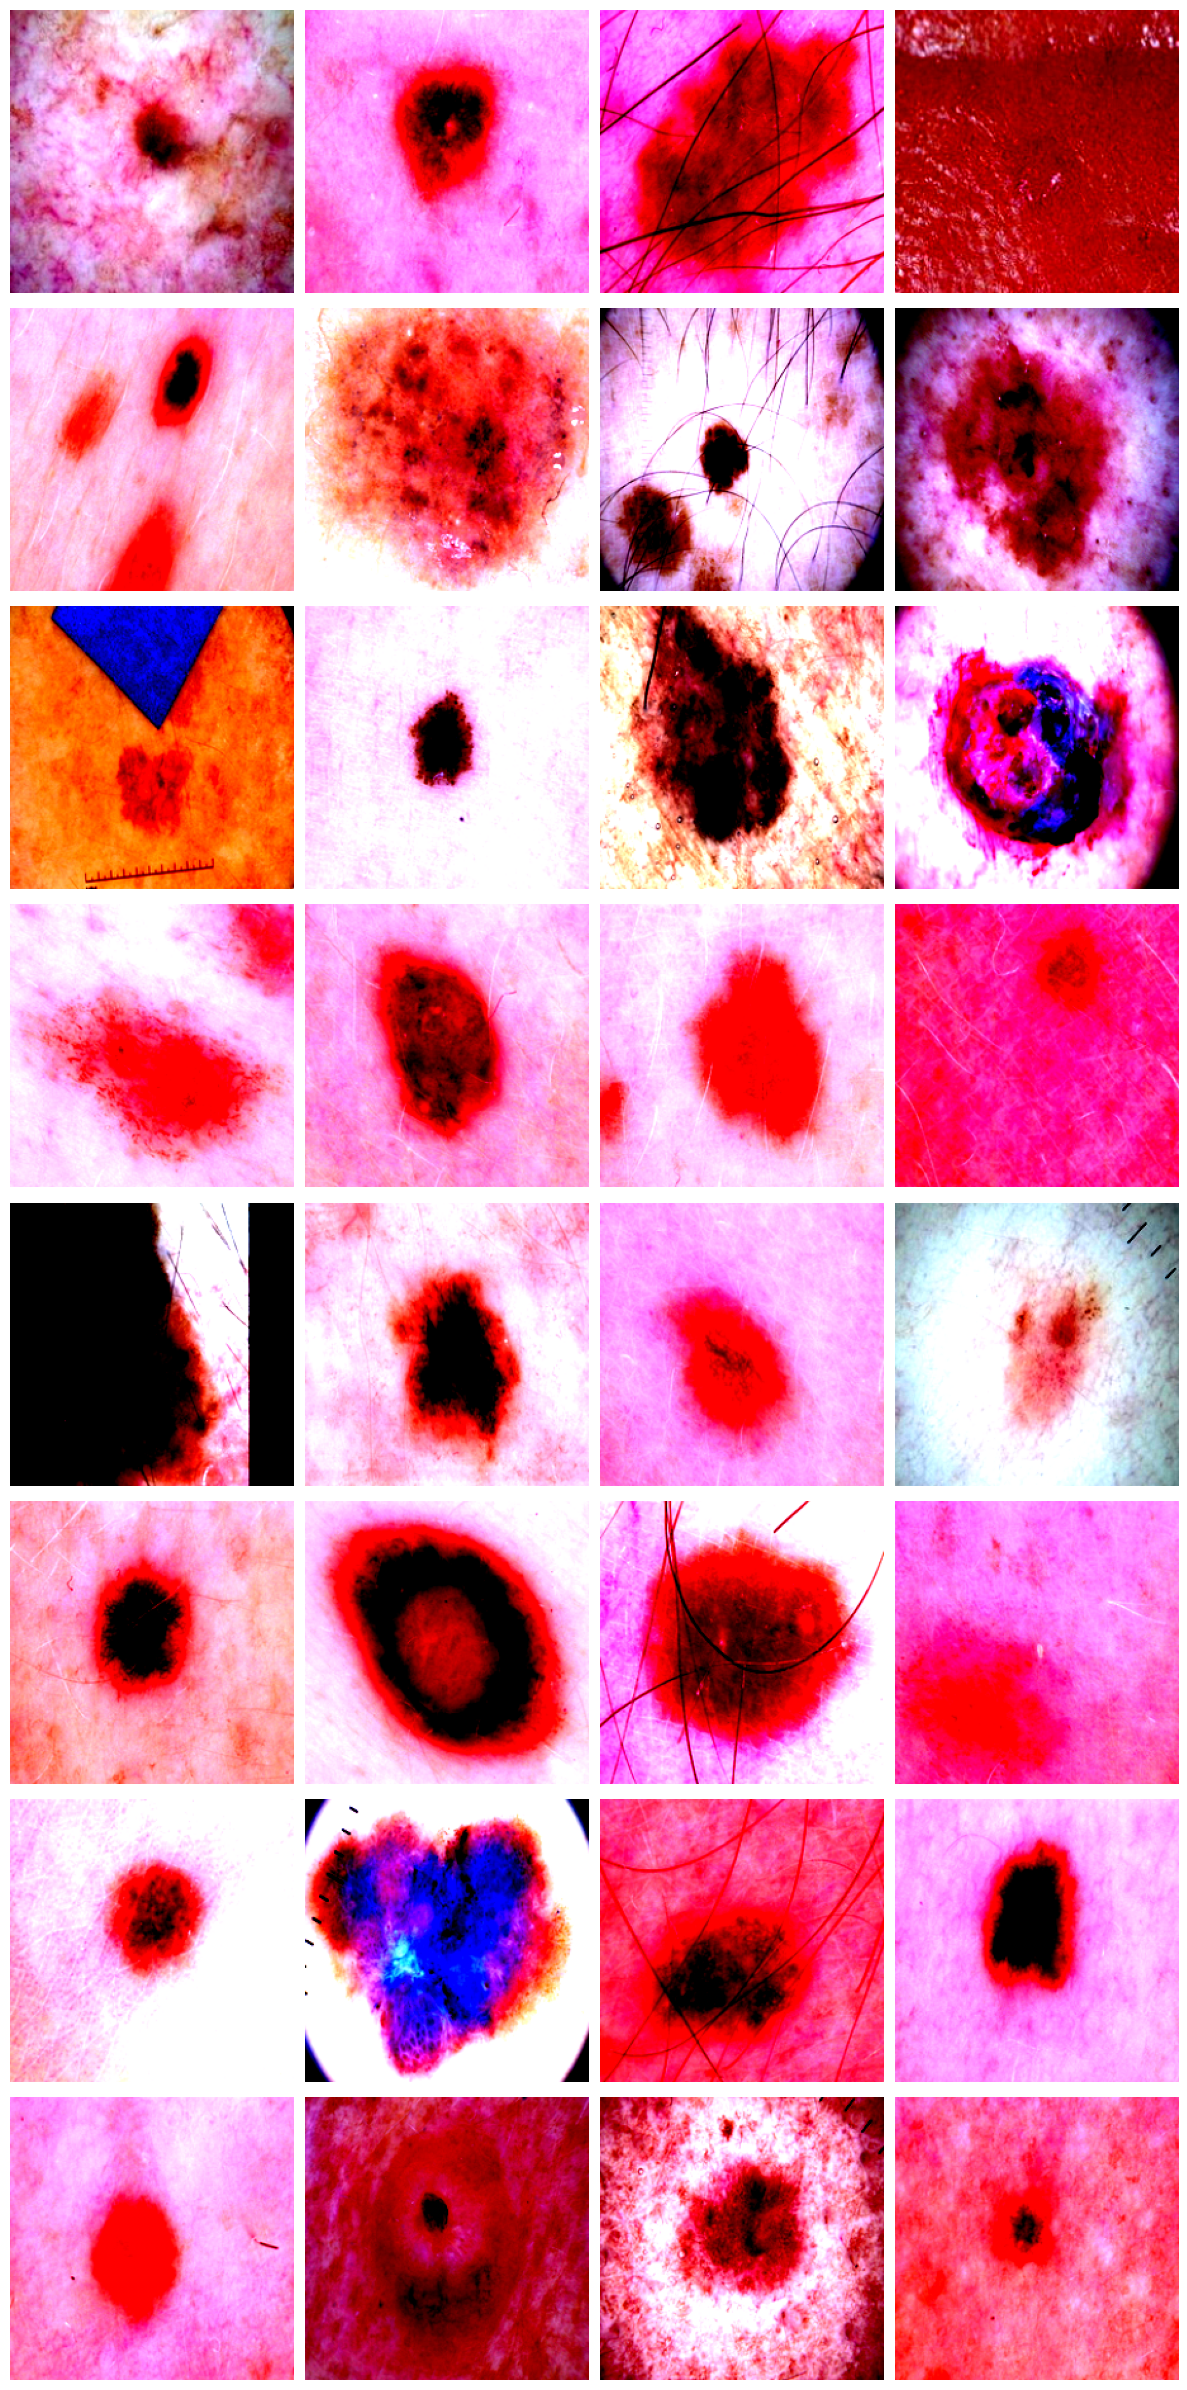

In [15]:
# We visualize the transformations that were applied.
fig,axs = plt.subplots(nrows = 8, ncols = 4, figsize = (12, 24))
axs = axs.flat

for i,img in enumerate(batch_images):
    image = img.permute(1,2,0)
    axs[i].imshow(image)
    axs[i].axis('off')

fig.tight_layout()
fig.show()

### Model

In [16]:
device="cuda" if torch.cuda.is_available() else "cpu" 
print(device)
from torchvision.models import resnet50
model=resnet50(weights=weights,).to(device=device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


In [17]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)   
num_ftrs


2048

In [18]:
for param in model.conv1.parameters():
    param.requires_grad = False
    
for param in model.bn1.parameters():
    param.requires_grad = False
    
for param in model.layer1.parameters():
    param.requires_grad = False
    
for param in model.layer2.parameters():
    param.requires_grad = False
    
for param in model.layer3.parameters():
    param.requires_grad = False
    
for param in model.layer4.parameters():
    param.requires_grad = False

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [20]:
from torchinfo import summary

summary(model = model,
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ResNet (ResNet)                          [32, 3, 224, 224] [32, 2]         --              Partial
├─Conv2d (conv1)                         [32, 3, 224, 224] [32, 64, 112, 112] (9,408)         False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] (128)           False
├─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --              --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56] --              --
├─Sequential (layer1)                    [32, 64, 56, 56] [32, 256, 56, 56] --              False
│    └─Bottleneck (0)                    [32, 64, 56, 56] [32, 256, 56, 56] --              False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56] [32, 64, 56, 56] (4,096)         False
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56] [32, 64, 56, 56] (128)           False
│    │    └─ReLU 

In [21]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=1, device="cuda"):
    model.to(device)
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for data, target in train_loader:
            data = data.to(device=device)
            target = target.to(device=device)

            optimizer.zero_grad()
            scores = model(data)
            loss = loss_fn(scores, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * data.size(0)

            _, predicted = torch.max(scores.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_acc_history.append(train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [22]:
def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device=device)
            target = target.to(device=device)

            scores = model(data)
            loss = loss_fn(scores, target)
            running_loss += loss.item() * data.size(0)

            _, predicted = torch.max(scores.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * correct / total

    return loss, accuracy

In [23]:
train(model,train_loader,val_loader,optimizer,loss_fn,1,"cuda")        
evaluate(model,train_loader,loss_fn,device)

Epoch [1/1], Train Loss: 0.4623, Train Accuracy: 78.85%, Val Loss: 0.3669, Val Accuracy: 84.09%


(0.3422733091414964, 85.49075391180655)

Epoch [1/20], Train Loss: 0.3476, Train Accuracy: 84.68%, Val Loss: 0.3540, Val Accuracy: 82.95%
Epoch [2/20], Train Loss: 0.3325, Train Accuracy: 85.96%, Val Loss: 0.3602, Val Accuracy: 83.33%
Epoch [3/20], Train Loss: 0.3034, Train Accuracy: 87.29%, Val Loss: 0.3500, Val Accuracy: 82.01%
Epoch [4/20], Train Loss: 0.3014, Train Accuracy: 86.72%, Val Loss: 0.3547, Val Accuracy: 82.77%
Epoch [5/20], Train Loss: 0.2840, Train Accuracy: 87.81%, Val Loss: 0.3307, Val Accuracy: 83.90%
Epoch [6/20], Train Loss: 0.2749, Train Accuracy: 87.96%, Val Loss: 0.3347, Val Accuracy: 83.33%
Epoch [7/20], Train Loss: 0.2632, Train Accuracy: 88.19%, Val Loss: 0.3422, Val Accuracy: 83.71%
Epoch [8/20], Train Loss: 0.2626, Train Accuracy: 89.05%, Val Loss: 0.3638, Val Accuracy: 83.90%
Epoch [9/20], Train Loss: 0.2524, Train Accuracy: 89.57%, Val Loss: 0.3346, Val Accuracy: 84.66%
Epoch [10/20], Train Loss: 0.2472, Train Accuracy: 90.23%, Val Loss: 0.3470, Val Accuracy: 83.52%
Epoch [11/20], Train Loss: 0.

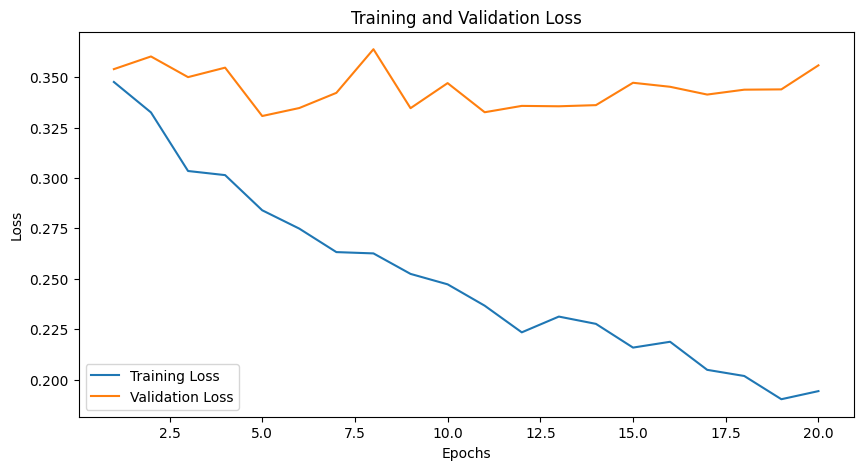

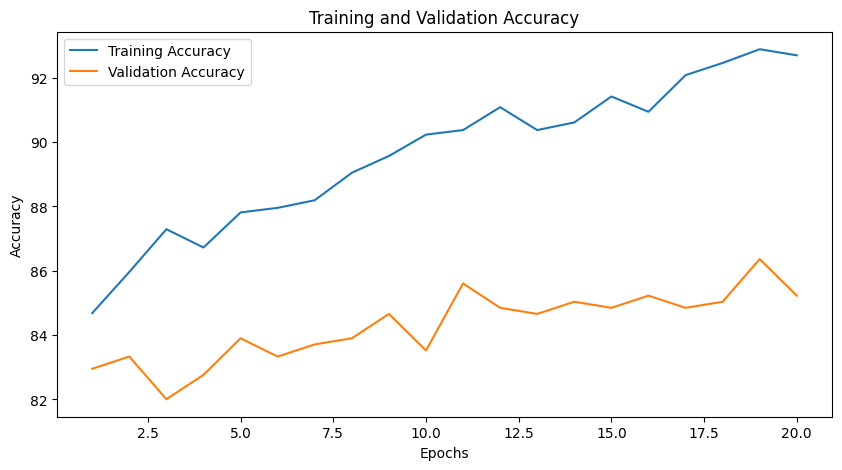

In [24]:
import matplotlib.pyplot as plt

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model, train_loader, val_loader, optimizer, loss_fn, epochs=20, device=device)

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
